In [2]:
import numpy as np
import surprise as surp
import seaborn as sns
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import Reader

In [180]:
Y_train = np.loadtxt('train.txt').astype(int)
Y_test = np.loadtxt('test.txt').astype(int)
print(np.max(Y_train[:,1]))
print(np.max(Y_test[:,1]))

1682
1678


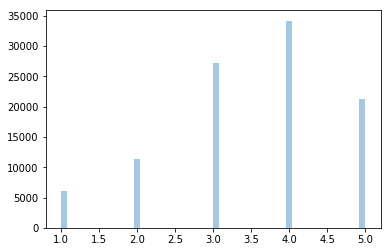

In [11]:
data = np.loadtxt('data.txt')

ratings = np.array(data[:, 2])
sns.distplot(ratings, kde=0)

In [142]:
reader = Reader(sep='\t')

data_load = Dataset.load_from_file('train.txt', reader)

trainset = data_load.build_full_trainset()
#algo = SVD(n_factors=20, reg_all=0.1, lr_all=.01)
algo = SVD(n_factors=20)

algo.fit(trainset)
U = algo.pu
V = algo.qi
a = algo.bu
b = algo.bi

In [122]:
print(a.shape)
print(b.shape)

(943,)
(1668,)


In [143]:
# print(a[:10])
# print(b[:10])
# print(a.shape)
# print(b.shape)
amat = np.array([list(a) for i in range(1668)])
# print(amat.T)
# print(amat.T.shape)
bmat = np.array([list(b) for i in range(943)])
# print(bmat)
# print(bmat.shape)


In [144]:
mu = np.mean(Y_train[:,2])
print(U.shape)
print(V.shape)
Y = (U@V.T + amat.T + bmat + np.full((943,1668), mu))
print(Y)
print(np.min(Y))
print(np.max(Y))

(943, 20)
(1668, 20)
[[3.87956747 4.09987217 2.57092084 ... 3.28695517 3.34533109 3.34169172]
 [4.13420936 4.31312676 2.5276101  ... 3.50950391 3.53154843 3.46732894]
 [3.92019141 4.03993808 2.56026878 ... 3.35670585 3.43593758 3.3534576 ]
 ...
 [3.77666011 3.98634967 2.3536611  ... 3.08837105 3.14984571 3.17009439]
 [3.49805535 3.60383939 2.18966081 ... 2.83697488 2.7284757  2.86017859]
 [4.13492874 4.52238257 2.93914983 ... 3.73819345 3.80873908 3.68498172]]
-0.21676810979701644
5.838777605576734


In [145]:
bad_movie_indices = []
movie_indices = {}
for i in range(1, 1683):
    movie_indices[i] = False
    
for i in range(len(Y_train)):
    movie_indices[Y_train[i, 1]] = True


for i in range(1, 1683):
    if movie_indices[i] == False:
        bad_movie_indices.append(i)
        
bad_movie_indices2 = []
movie_indices2 = {}
for i in range(1, 1683):
    movie_indices2[i] = False
    
for i in range(len(Y_test)):
    movie_indices2[Y_test[i, 1]] = True

for i in range(1, 1683):
    if movie_indices2[i] == False:
        bad_movie_indices2.append(i)
        
print(bad_movie_indices)              
        
#print(bad_movie_indices2)        

[1349, 1363, 1458, 1541, 1561, 1576, 1579, 1581, 1606, 1633, 1651, 1666, 1667, 1678]


In [129]:
print(V[1567])

[ 0.2069999   0.0170579   0.1086641  -0.1941561   0.06803999 -0.01849915
  0.15914248  0.14568169 -0.00716286 -0.13649337 -0.01892722 -0.24132824
  0.21016232 -0.00203577 -0.05976506  0.01592877 -0.1123736  -0.14053913
 -0.01761981  0.0133105 ]


In [146]:
zer = np.zeros(20)
print(V.shape)
for i in range(14):
    V = np.insert(V, bad_movie_indices[i] - 1, zer, axis=0)
    b = np.insert(b, bad_movie_indices[i] - 1, 0, axis=0)
    print(V.shape)
print(V[1572]) 

(1668, 20)
(1669, 20)
(1670, 20)
(1671, 20)
(1672, 20)
(1673, 20)
(1674, 20)
(1675, 20)
(1676, 20)
(1677, 20)
(1678, 20)
(1679, 20)
(1680, 20)
(1681, 20)
(1682, 20)
[ 0.17256268 -0.01273853 -0.05570346  0.03689465  0.06584919 -0.03769048
  0.05883852 -0.02991023  0.08778865 -0.18101506  0.03121451  0.09167226
  0.10202898 -0.05090818  0.00339248 -0.05404793 -0.24010959 -0.12887011
  0.01107676 -0.00139619]


In [147]:
print(U.shape)
print(V.shape)
print(a.shape)
print(b.shape)
print(Y_test.shape)
print(Y.shape)

(943, 20)
(1682, 20)
(943,)
(1682,)
(10000, 3)
(943, 1668)


In [177]:
def get_err(U, V, Y, A, B, bias, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    if bias: 
        first_term = 0.5*reg*(np.linalg.norm(U, ord='fro')**2 + np.linalg.norm(V, ord='fro')**2 + np.linalg.norm(A)**2 + np.linalg.norm(B)**2)
        second_term = 0
        for index in range(len(Y)):
            (i, j, Yij) = Y[index]
            second_term += (0.5 * (Yij - (np.dot(U[i - 1], V[j - 1]) + A[i-1] + B[j-1] + mu))**2 )
        return (first_term + second_term)/len(Y)
    
    else:
        first_term = 0.5*reg*(np.linalg.norm(U, ord='fro')**2 + np.linalg.norm(V, ord='fro')**2)
        second_term = 0
        for index in range(len(Y)):
            (i, j, Yij) = Y[index]
            second_term += (0.5 * (Yij - (np.dot(U[i - 1], V[j - 1]))))
        return (first_term + second_term)/len(Y)

In [179]:
eout = get_err(U, V, Y_test, a,b, True, mu)
print(eout)

0.7815989749051808


In [187]:
Y_train = np.loadtxt('train.txt').astype(int)
Y_test = np.loadtxt('test.txt').astype(int)
mu = np.mean(Y_train[:,2])
reader = Reader(sep='\t')
data_load = Dataset.load_from_file('train.txt', reader)
trainset = data_load.build_full_trainset()


k = 20
regs = [10**-4, 3 * (10**-4), 10**-3, 3 * (10**-3), 10**-2, 3 * (10**-2), 10**-1, 3 * (10**-1), 1, 3, 10, 30, 100, 300]
regs2 = [1, 3, 10, 30, 100]
etas = [0.03, 0.01, 0.003, 0.001, 0.0003]  # learning rate
E_outs = []

bad_movie_indices = []
movie_indices = {}
for i in range(1, 1683):
    movie_indices[i] = False
    
for i in range(len(Y_train)):
    movie_indices[Y_train[i, 1]] = True


for i in range(1, 1683):
    if movie_indices[i] == False:
        bad_movie_indices.append(i)
        
bias = True
# Use to compute Ein and Eout
for reg in regs2:
    E_outs_for_lambda = []

    for eta in etas:
        print("Training model with k = %s, eta = %s, reg = %s"%(k, eta, reg))
        #U,V, e_in, A, B = train_model(M, N, k, eta, reg, Y_train, bias)

        algo = SVD(n_factors=20, reg_all=reg, lr_all=eta)

        algo.fit(trainset)
        U = algo.pu
        V = algo.qi
        a = algo.bu
        b = algo.bi
        zer = np.zeros(20)
        for i in range(14):
            V = np.insert(V, bad_movie_indices[i] - 1, zer, axis=0)
            b = np.insert(b, bad_movie_indices[i] - 1, 0, axis=0)

        eout = get_err(U, V, Y_test, a,b, True, mu)
        E_outs_for_lambda.append(eout)

    E_outs.append(E_outs_for_lambda)
    


Training model with k = 20, eta = 0.03, reg = 1
Training model with k = 20, eta = 0.01, reg = 1
Training model with k = 20, eta = 0.003, reg = 1
Training model with k = 20, eta = 0.001, reg = 1
Training model with k = 20, eta = 0.0003, reg = 1
Training model with k = 20, eta = 0.03, reg = 3
Training model with k = 20, eta = 0.01, reg = 3
Training model with k = 20, eta = 0.003, reg = 3
Training model with k = 20, eta = 0.001, reg = 3
Training model with k = 20, eta = 0.0003, reg = 3
Training model with k = 20, eta = 0.03, reg = 10
Training model with k = 20, eta = 0.01, reg = 10
Training model with k = 20, eta = 0.003, reg = 10
Training model with k = 20, eta = 0.001, reg = 10
Training model with k = 20, eta = 0.0003, reg = 10
Training model with k = 20, eta = 0.03, reg = 30
Training model with k = 20, eta = 0.01, reg = 30
Training model with k = 20, eta = 0.003, reg = 30
Training model with k = 20, eta = 0.001, reg = 30
Training model with k = 20, eta = 0.0003, reg = 30
Training model

In [188]:
print(E_outs)

[[0.6631677945653168, 0.6596119170582361, 0.6562710118966515, 0.6489417026773672, 0.638438681976918], [0.6329020618999902, 0.6305938640913279, 0.6308003326984057, 0.6311211541305163, 0.6307359935780402], [0.6285022376785441, 0.6270549185856609, 0.6269819456970651, 0.6274847298760535, 0.6283321854484982], [0.6299448314197618, 0.6290964733289398, 0.6288835307355424, 0.6289716848684809, 0.6292458448744724], [nan, 0.6303036064223623, 0.6302134473064332, 0.6301831384035997, 0.6302202956450131]]


In [ ]:
#reg = 10, eta = .003

In [183]:
print(Y[771,312])
print(Y_test[2])

3.1115965959532215
[772 313   5]


In [3]:
# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k')

# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9348  0.9292  0.9303  0.9445  0.9422  0.9362  0.0062  
MAE (testset)     0.7391  0.7333  0.7326  0.7430  0.7409  0.7378  0.0041  
Fit time          4.15    3.93    4.07    3.96    4.12    4.05    0.09    
Test time         0.12    0.16    0.15    0.12    0.16    0.14    0.02    


{'test_rmse': array([0.93482396, 0.92915288, 0.93030116, 0.94447262, 0.94224945]),
 'test_mae': array([0.73909771, 0.73330086, 0.73263821, 0.74296981, 0.74085247]),
 'fit_time': (4.1506571769714355,
  3.928983211517334,
  4.068084955215454,
  3.9630918502807617,
  4.118180751800537),
 'test_time': (0.12432193756103516,
  0.1621990203857422,
  0.1530601978302002,
  0.11680102348327637,
  0.15660595893859863)}

In [22]:
# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k')

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9320


0.9320481393241525